# Learn To Synchronize Videos

## Model declaration

In [1]:
from importlib import reload
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import numpy as np
import os
from matplotlib import pyplot as plt
import sync_net
import trainer
import metrics
import data_loader
reload(sync_net)
reload(trainer)
reload(metrics)
reload(data_loader)
from sync_net import reset_first_layer, replace_last_layer, add_sigmoid_activation, TripletNet, MultiSiameseNet, TripletLoss, CosineSimilarityTripletLoss, LosslessTripletLoss, MultiSiameseCosineSimilarityLoss
from data_loader import get_datasets, get_test_set, get_multisiamese_datasets
from trainer import fit
from metrics import EmbeddingL2DistanceMetric, EmbeddingCosineSimilarityMetric
# import wandb
# wandb.init(project="learn-to-synchronize-videos")
cuda = torch.cuda.is_available()

torch.cuda.set_device(0)
embedding_net = models.resnet50(pretrained=True)
reset_first_layer(embedding_net)
replace_last_layer(embedding_net, 16)
# embedding_net = add_sigmoid_activation(embedding_net)  # Use only with LosslessTripletLoss
# model = TripletNet(embedding_net)
model = MultiSiameseNet(embedding_net)
model.cuda(0)
model = nn.DataParallel(model).cuda()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# loss_fn = TripletLoss(margin=0.5)
# loss_fn = CosineSimilarityTripletLoss(margin=0.5)
# loss_fn = LosslessTripletLoss()
loss_fn = MultiSiameseCosineSimilarityLoss()
scheduler = lr_scheduler.StepLR(optimizer, 5, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100
start_epoch = 0
save_path = r"C:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\angio_seq_multisiamese_metrics"
if not os.path.isdir(save_path):
    os.makedirs(save_path)
# wandb.config.lr = lr
# wandb.config.optimizer = type(optimizer)
# wandb.config.loss_fn = type(loss_fn)

## Load dataset

### Angio sequence triplets

In [ ]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_path = r'C:\Users\root\Data\Angiographie\KR-11'
training_set, validation_set = get_datasets(training_path, validation_path)

### Angio sequence multi siamese

In [2]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_path = r'C:\Users\root\Data\Angiographie\KR-11'
training_set, validation_set = get_multisiamese_datasets(training_path, validation_path, 1000, 64)

105 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30LAO25CAU
110 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO
104 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO25CAU
78 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_AP
79 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_LAT
121 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_AP
113 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_LAT
75 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30LAO25CRA
78 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30RAO
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_AP
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_LAT
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_AP
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_LAT
48 valid frames in C:\Users\root\Data\Angiogr

### Load MNIST dataset instead

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transformations = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])
mnist_trainset = datasets.MNIST(r"C:\Users\root\Data\MNIST", train=True, download=True, transform=transformations)

In [ ]:
from PIL import Image
from torch.utils.data import Dataset

class TripletMNIST(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1 = self.test_data[self.test_triplets[index][0]]
            img2 = self.test_data[self.test_triplets[index][1]]
            img3 = self.test_data[self.test_triplets[index][2]]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        img3 = Image.fromarray(img3.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return (img1, img2, img3)

    def __len__(self):
        return len(self.mnist_dataset)
    
    
triplet_mnist = TripletMNIST(mnist_trainset)
train_loader = DataLoader(triplet_mnist, batch_size=20, shuffle=True, num_workers=0)
# for batch_index, triplet in enumerate(train_loader):
#     for i, image in enumerate(triplet):
#         print(f"batch {batch_index}, i {i}, triplet {image.numpy().shape}")
#         plt.subplot(1, 3, i+1)
#         plt.imshow(image.view(224, 224).numpy())
#         plt.title("Anchor" if i == 0 else "Positive" if i == 1 else "Negative")
#     plt.show()
metrics = [EmbeddingL2DistanceMetric(), EmbeddingCosineSimilarityMetric()]
fit(train_loader, None, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics)

## Load training state

In [ ]:
load_state_path = save_path + r"\training_state_0.pth"
print(load_state_path)
state = torch.load(load_state_path)

start_epoch = int(state['epoch']) + 1
model.load_state_dict(state['model'])
optimizer.load_state_dict(state['optimizer'])
scheduler.load_state_dict(state['scheduler'])

## Train

In [ ]:
torch.cuda.empty_cache()  # Doesn't always work to free the GPU memory

### Angio sequence triplets

In [ ]:
train_loader = DataLoader(training_set, batch_size=20, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_set, batch_size=20, shuffle=True, num_workers=4)
metrics = [EmbeddingL2DistanceMetric(), EmbeddingCosineSimilarityMetric()]
fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics, measure_weights=True)

### Angio sequence multisiamese

Starting Epoch 0
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 1.982648	Elapsed time: 0:00:02.279825	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.83, 0.812)	FCWeights (Diff, Avg, Total): (32.735084533691406, 0.026996195316314697, 884.611328125)
Train: [6400/1000 (10%)]	Loss: 1.375655	Elapsed time: 0:00:40.444983	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.409, -0.209)	FCWeights (Diff, Avg, Total): (5.103326797485352, 0.027837378904223442, 912.1752319335938)
Train: [12000/1000 (20%)]	Loss: 1.271951	Elapsed time: 0:01:17.891829	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.42, -0.251)	FCWeights (Diff, Avg, Total): (3.075120449066162, 0.028300024569034576, 927.335205078125)
Train: [13200/1000 (30%)]	Loss: 1.240875	Elapsed time: 0:01:55.198853	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.425, -0.276)	FCWeights (Diff, Avg, Total): (2.626443862915039, 0.02865099161863327, 938.835693359375)
Train: [25600/1000 (40%)]	Loss: 1.312477	Elapsed time: 0:02:33.063278	Embedd

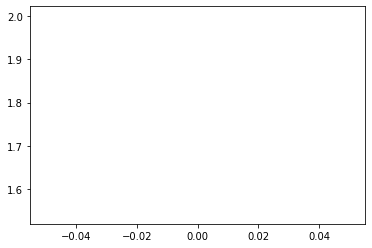

Starting Epoch 1
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 1.888760	Elapsed time: 0:00:00.310995	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.089, -0.021)	FCWeights (Diff, Avg, Total): (2.2835144996643066, 0.03302552178502083, 1082.1802978515625)
Train: [4500/1000 (10%)]	Loss: 1.608508	Elapsed time: 0:00:39.233869	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.288, -0.1)	FCWeights (Diff, Avg, Total): (1.234027624130249, 0.033280424773693085, 1090.532958984375)
Train: [12800/1000 (20%)]	Loss: 1.229951	Elapsed time: 0:01:18.681307	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.351, -0.227)	FCWeights (Diff, Avg, Total): (1.5936692953109741, 0.03341691568493843, 1095.0054931640625)
Train: [19200/1000 (30%)]	Loss: 1.283611	Elapsed time: 0:01:58.163449	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.364, -0.259)	FCWeights (Diff, Avg, Total): (4.668756008148193, 0.03353950381278992, 1099.0224609375)
Train: [16800/1000 (40%)]	Loss: 1.473005	Elapsed time: 0:02:36.754810	

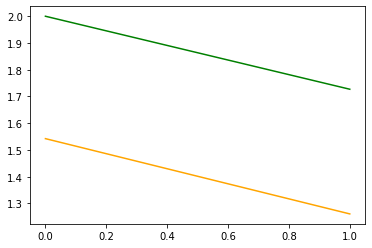

Starting Epoch 2
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 1.413774	Elapsed time: 0:00:00.456995	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.288, -0.297)	FCWeights (Diff, Avg, Total): (7.28028678894043, 0.03751548379659653, 1229.307373046875)
Train: [4200/1000 (10%)]	Loss: 1.063597	Elapsed time: 0:00:40.365391	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.496, -0.436)	FCWeights (Diff, Avg, Total): (7.321603775024414, 0.0381317213177681, 1249.500244140625)
Train: [8800/1000 (20%)]	Loss: 0.998352	Elapsed time: 0:01:18.947693	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.514, -0.452)	FCWeights (Diff, Avg, Total): (3.6958723068237305, 0.03840725123882294, 1258.52880859375)
Train: [19200/1000 (30%)]	Loss: 0.965002	Elapsed time: 0:01:57.438922	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.523, -0.466)	FCWeights (Diff, Avg, Total): (1.4666109085083008, 0.03851625323295593, 1262.1005859375)
Train: [20000/1000 (40%)]	Loss: 0.986459	Elapsed time: 0:02:36.184229	Embed

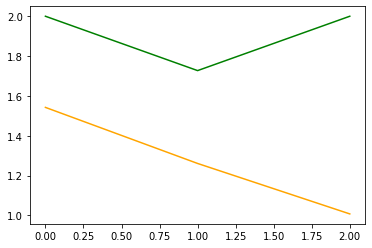

Starting Epoch 3
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 1.217243	Elapsed time: 0:00:00.419149	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.425, -0.357)	FCWeights (Diff, Avg, Total): (0.7150474190711975, 0.041652485728263855, 1364.86865234375)
Train: [6300/1000 (10%)]	Loss: 0.970182	Elapsed time: 0:00:39.356105	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.539, -0.488)	FCWeights (Diff, Avg, Total): (3.1505987644195557, 0.041945308446884155, 1374.4638671875)
Train: [10200/1000 (20%)]	Loss: 1.020480	Elapsed time: 0:01:19.300752	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.527, -0.476)	FCWeights (Diff, Avg, Total): (0.4269018769264221, 0.04240529239177704, 1389.53662109375)
Train: [14400/1000 (30%)]	Loss: 1.008477	Elapsed time: 0:01:59.032320	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.523, -0.476)	FCWeights (Diff, Avg, Total): (8.572547912597656, 0.04278368875384331, 1401.9359130859375)
Train: [25600/1000 (40%)]	Loss: 0.960597	Elapsed time: 0:02:37.199860

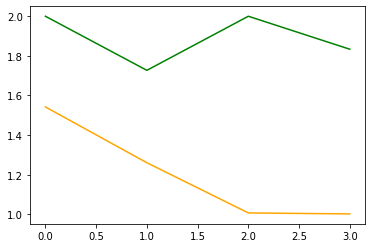

Starting Epoch 4
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 1.331809	Elapsed time: 0:00:00.454680	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.334, -0.333)	FCWeights (Diff, Avg, Total): (0.15139062702655792, 0.04699179530143738, 1539.8271484375)
Train: [4900/1000 (10%)]	Loss: 1.176780	Elapsed time: 0:00:39.696413	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.428, -0.393)	FCWeights (Diff, Avg, Total): (0.19619303941726685, 0.04697948694229126, 1539.423828125)
Train: [9800/1000 (20%)]	Loss: 1.086756	Elapsed time: 0:01:18.149776	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.448, -0.418)	FCWeights (Diff, Avg, Total): (0.1250377744436264, 0.046954259276390076, 1538.59716796875)
Train: [12900/1000 (30%)]	Loss: 1.024891	Elapsed time: 0:01:57.500690	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.464, -0.438)	FCWeights (Diff, Avg, Total): (0.37068092823028564, 0.046946700662374496, 1538.3494873046875)
Train: [19600/1000 (40%)]	Loss: 0.976988	Elapsed time: 0:02:34.55374

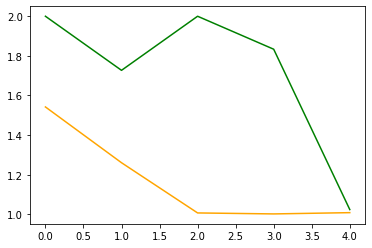

Starting Epoch 5
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 1.021545	Elapsed time: 0:00:00.292984	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.486, -0.491)	FCWeights (Diff, Avg, Total): (0.5611359477043152, 0.04702463001012802, 1540.903076171875)
Train: [5800/1000 (10%)]	Loss: 0.953707	Elapsed time: 0:00:39.054855	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.532, -0.512)	FCWeights (Diff, Avg, Total): (0.08261169493198395, 0.047027718275785446, 1541.0042724609375)
Train: [9400/1000 (20%)]	Loss: 0.905936	Elapsed time: 0:01:16.870486	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.544, -0.525)	FCWeights (Diff, Avg, Total): (0.08072501420974731, 0.047031890600919724, 1541.1409912109375)
Train: [18000/1000 (30%)]	Loss: 0.917742	Elapsed time: 0:01:55.368870	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.546, -0.527)	FCWeights (Diff, Avg, Total): (0.5819249153137207, 0.04703911393880844, 1541.377685546875)
Train: [25600/1000 (40%)]	Loss: 0.948104	Elapsed time: 0:02:33

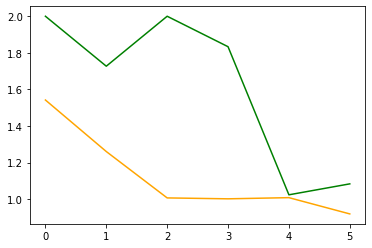

Starting Epoch 6
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 0.564515	Elapsed time: 0:00:00.281997	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.709, -0.726)	FCWeights (Diff, Avg, Total): (0.154651939868927, 0.047107160091400146, 1543.607421875)
Train: [4600/1000 (10%)]	Loss: 0.930362	Elapsed time: 0:00:38.753853	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.548, -0.524)	FCWeights (Diff, Avg, Total): (0.6330141425132751, 0.047107260674238205, 1543.6107177734375)
Train: [12800/1000 (20%)]	Loss: 0.844293	Elapsed time: 0:01:16.496328	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.57, -0.544)	FCWeights (Diff, Avg, Total): (0.0381338894367218, 0.0471082404255867, 1543.642822265625)
Train: [15000/1000 (30%)]	Loss: 0.896520	Elapsed time: 0:01:55.372440	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.566, -0.543)	FCWeights (Diff, Avg, Total): (0.15549667179584503, 0.04710160568356514, 1543.4254150390625)
Train: [14800/1000 (40%)]	Loss: 0.919067	Elapsed time: 0:02:33.83053

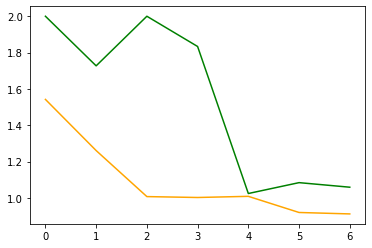

Starting Epoch 7
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 0.812435	Elapsed time: 0:00:00.290995	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.612, -0.574)	FCWeights (Diff, Avg, Total): (0.05172491818666458, 0.04717862233519554, 1545.9490966796875)
Train: [4300/1000 (10%)]	Loss: 0.894953	Elapsed time: 0:00:39.531202	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.568, -0.537)	FCWeights (Diff, Avg, Total): (0.060662902891635895, 0.04718250036239624, 1546.076171875)
Train: [8800/1000 (20%)]	Loss: 0.915731	Elapsed time: 0:01:19.138440	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.562, -0.532)	FCWeights (Diff, Avg, Total): (0.865990936756134, 0.047193966805934906, 1546.451904296875)
Train: [15600/1000 (30%)]	Loss: 0.892151	Elapsed time: 0:01:58.125157	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.564, -0.534)	FCWeights (Diff, Avg, Total): (0.11574820429086685, 0.04719288647174835, 1546.41650390625)
Train: [25600/1000 (40%)]	Loss: 0.860220	Elapsed time: 0:02:37.0779

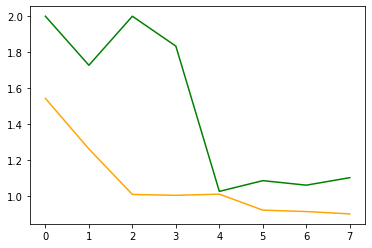

Starting Epoch 8
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 1.203375	Elapsed time: 0:00:00.456999	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.385, -0.411)	FCWeights (Diff, Avg, Total): (0.12640368938446045, 0.04726512357592583, 1548.7835693359375)
Train: [6400/1000 (10%)]	Loss: 0.851392	Elapsed time: 0:00:38.194007	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.584, -0.56)	FCWeights (Diff, Avg, Total): (0.1412210315465927, 0.04726938530802727, 1548.9232177734375)
Train: [12800/1000 (20%)]	Loss: 0.850489	Elapsed time: 0:01:16.651771	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.587, -0.559)	FCWeights (Diff, Avg, Total): (0.09032383561134338, 0.04727401211857796, 1549.0748291015625)
Train: [12300/1000 (30%)]	Loss: 0.926280	Elapsed time: 0:01:55.505023	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.574, -0.548)	FCWeights (Diff, Avg, Total): (0.20679493248462677, 0.04728114977478981, 1549.3087158203125)
Train: [20000/1000 (40%)]	Loss: 0.848759	Elapsed time: 0:02:3

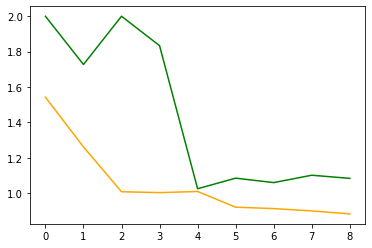

Starting Epoch 9
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 0.739043	Elapsed time: 0:00:00.292477	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.665, -0.595)	FCWeights (Diff, Avg, Total): (0.0313958041369915, 0.04736211150884628, 1551.961669921875)
Train: [5100/1000 (10%)]	Loss: 0.897073	Elapsed time: 0:00:39.623564	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.569, -0.534)	FCWeights (Diff, Avg, Total): (0.034562259912490845, 0.04736251384019852, 1551.974853515625)
Train: [12800/1000 (20%)]	Loss: 0.904752	Elapsed time: 0:01:19.057499	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.563, -0.536)	FCWeights (Diff, Avg, Total): (0.01662108488380909, 0.047363076359033585, 1551.9932861328125)
Train: [14700/1000 (30%)]	Loss: 0.930115	Elapsed time: 0:01:58.699819	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.559, -0.53)	FCWeights (Diff, Avg, Total): (0.020818110555410385, 0.04736394062638283, 1552.0216064453125)
Train: [19200/1000 (40%)]	Loss: 0.870771	Elapsed time: 0:02:

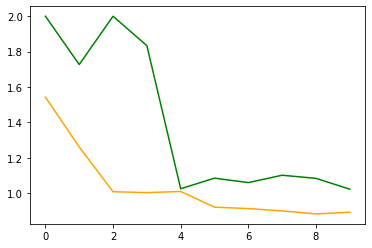

Starting Epoch 10
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 0.871345	Elapsed time: 0:00:00.373002	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.589, -0.539)	FCWeights (Diff, Avg, Total): (0.09373359382152557, 0.04736756533384323, 1552.140380859375)
Train: [3700/1000 (10%)]	Loss: 0.862735	Elapsed time: 0:00:37.906621	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.58, -0.557)	FCWeights (Diff, Avg, Total): (0.015398848801851273, 0.047368139028549194, 1552.1591796875)
Train: [8200/1000 (20%)]	Loss: 0.841478	Elapsed time: 0:01:15.135901	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.585, -0.562)	FCWeights (Diff, Avg, Total): (0.14218929409980774, 0.047368407249450684, 1552.16796875)
Train: [13200/1000 (30%)]	Loss: 0.853934	Elapsed time: 0:01:53.811871	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.584, -0.562)	FCWeights (Diff, Avg, Total): (0.007863466627895832, 0.04736873507499695, 1552.1787109375)
Train: [25600/1000 (40%)]	Loss: 0.862086	Elapsed time: 0:02:32.46109

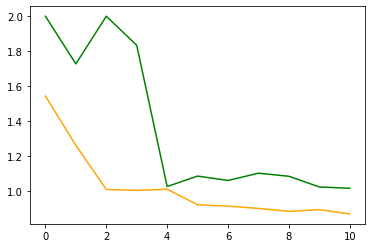

Starting Epoch 11
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 0.833313	Elapsed time: 0:00:00.463171	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.604, -0.562)	FCWeights (Diff, Avg, Total): (0.004973521456122398, 0.04737060144543648, 1552.2398681640625)
Train: [6400/1000 (10%)]	Loss: 0.906553	Elapsed time: 0:00:39.808546	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.557, -0.536)	FCWeights (Diff, Avg, Total): (0.004512467887252569, 0.04737023264169693, 1552.227783203125)
Train: [7800/1000 (20%)]	Loss: 0.869093	Elapsed time: 0:01:18.175750	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.568, -0.544)	FCWeights (Diff, Avg, Total): (0.003877729643136263, 0.04737004265189171, 1552.2215576171875)
Train: [14100/1000 (30%)]	Loss: 0.851738	Elapsed time: 0:01:55.083256	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.575, -0.549)	FCWeights (Diff, Avg, Total): (0.12855865061283112, 0.047369927167892456, 1552.2177734375)
Train: [17600/1000 (40%)]	Loss: 0.869687	Elapsed time: 0:02

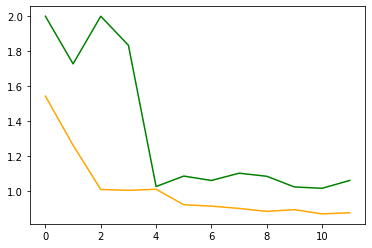

Starting Epoch 12
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 0.691818	Elapsed time: 0:00:00.345668	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.692, -0.615)	FCWeights (Diff, Avg, Total): (0.01702946051955223, 0.0473715178668499, 1552.2698974609375)
Train: [5800/1000 (10%)]	Loss: 0.896121	Elapsed time: 0:00:40.132729	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.562, -0.543)	FCWeights (Diff, Avg, Total): (0.045992136001586914, 0.047371312975883484, 1552.26318359375)
Train: [9800/1000 (20%)]	Loss: 0.835644	Elapsed time: 0:01:18.659094	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.578, -0.556)	FCWeights (Diff, Avg, Total): (0.021929973736405373, 0.04737050086259842, 1552.236572265625)
Train: [13200/1000 (30%)]	Loss: 0.874681	Elapsed time: 0:01:57.038643	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.576, -0.554)	FCWeights (Diff, Avg, Total): (0.004708247724920511, 0.04737100005149841, 1552.2529296875)
Train: [18800/1000 (40%)]	Loss: 0.846024	Elapsed time: 0:02:35

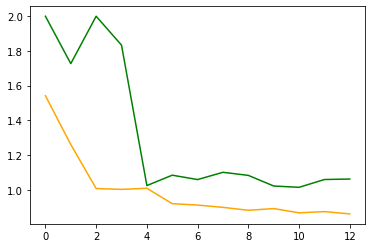

Starting Epoch 13
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 0.513747	Elapsed time: 0:00:00.292145	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.731, -0.754)	FCWeights (Diff, Avg, Total): (0.006798585411161184, 0.04737301915884018, 1552.319091796875)
Train: [3700/1000 (10%)]	Loss: 0.863443	Elapsed time: 0:00:38.724896	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.58, -0.559)	FCWeights (Diff, Avg, Total): (0.016382209956645966, 0.047372277826070786, 1552.2947998046875)
Train: [8400/1000 (20%)]	Loss: 0.815054	Elapsed time: 0:01:16.984283	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.592, -0.57)	FCWeights (Diff, Avg, Total): (0.022573180496692657, 0.04737330228090286, 1552.328369140625)
Train: [15000/1000 (30%)]	Loss: 0.890926	Elapsed time: 0:01:55.214834	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.582, -0.561)	FCWeights (Diff, Avg, Total): (0.01105661690235138, 0.04737427830696106, 1552.3603515625)
Train: [15600/1000 (40%)]	Loss: 0.888215	Elapsed time: 0:02:34

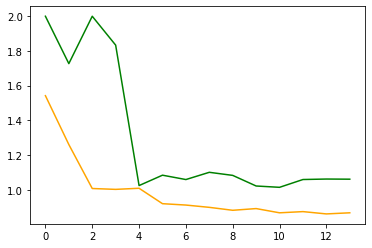

Starting Epoch 14
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 1.223511	Elapsed time: 0:00:00.450445	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.348, -0.428)	FCWeights (Diff, Avg, Total): (0.01889675296843052, 0.04737672954797745, 1552.440673828125)
Train: [6400/1000 (10%)]	Loss: 0.839904	Elapsed time: 0:00:39.135172	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.59, -0.565)	FCWeights (Diff, Avg, Total): (0.006591256707906723, 0.047376848757267, 1552.444580078125)
Train: [12800/1000 (20%)]	Loss: 0.927783	Elapsed time: 0:01:18.600954	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.566, -0.547)	FCWeights (Diff, Avg, Total): (0.0014554078225046396, 0.047376807779073715, 1552.4432373046875)
Train: [8700/1000 (30%)]	Loss: 0.896764	Elapsed time: 0:01:57.459924	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.564, -0.545)	FCWeights (Diff, Avg, Total): (0.0009568333043716848, 0.047376856207847595, 1552.44482421875)
Train: [25600/1000 (40%)]	Loss: 0.895261	Elapsed time: 0:02

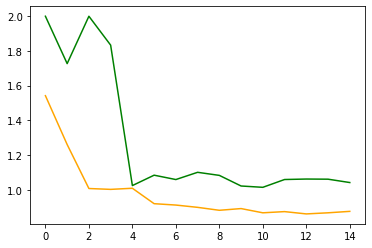

Starting Epoch 15
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 0.764667	Elapsed time: 0:00:00.453135	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.652, -0.583)	FCWeights (Diff, Avg, Total): (0.014374222606420517, 0.04737722873687744, 1552.45703125)
Train: [6400/1000 (10%)]	Loss: 0.893725	Elapsed time: 0:00:39.036943	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.57, -0.536)	FCWeights (Diff, Avg, Total): (0.004339441657066345, 0.047377295792102814, 1552.459228515625)
Train: [10000/1000 (20%)]	Loss: 0.840402	Elapsed time: 0:01:17.374536	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.578, -0.554)	FCWeights (Diff, Avg, Total): (0.0013776221312582493, 0.047377221286296844, 1552.456787109375)
Train: [19200/1000 (30%)]	Loss: 0.866780	Elapsed time: 0:01:54.836195	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.578, -0.555)	FCWeights (Diff, Avg, Total): (0.0054251933470368385, 0.04737734794616699, 1552.4609375)
Train: [15600/1000 (40%)]	Loss: 0.891265	Elapsed time: 0:02:33.9

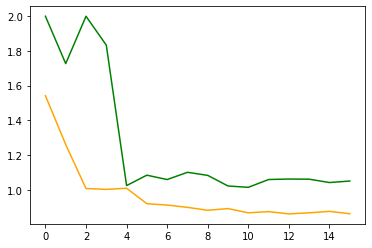

Starting Epoch 16
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 0.767128	Elapsed time: 0:00:00.456118	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.647, -0.585)	FCWeights (Diff, Avg, Total): (0.0014622980961576104, 0.047377485781908035, 1552.4654541015625)
Train: [4400/1000 (10%)]	Loss: 0.854010	Elapsed time: 0:00:38.610211	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.586, -0.56)	FCWeights (Diff, Avg, Total): (0.0009814591612666845, 0.04737747460603714, 1552.465087890625)
Train: [9600/1000 (20%)]	Loss: 0.925129	Elapsed time: 0:01:17.251256	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.567, -0.543)	FCWeights (Diff, Avg, Total): (0.008719127625226974, 0.04737752676010132, 1552.466796875)
Train: [14700/1000 (30%)]	Loss: 0.846985	Elapsed time: 0:01:55.265206	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.573, -0.551)	FCWeights (Diff, Avg, Total): (0.0029131120536476374, 0.04737740010023117, 1552.462646484375)
Train: [19600/1000 (40%)]	Loss: 0.854050	Elapsed time: 0:0

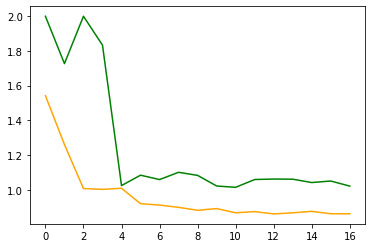

Starting Epoch 17
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 0.594542	Elapsed time: 0:00:00.336994	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.69, -0.715)	FCWeights (Diff, Avg, Total): (0.00019682664424180984, 0.04737754538655281, 1552.4674072265625)
Train: [4700/1000 (10%)]	Loss: 0.843113	Elapsed time: 0:00:39.481759	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.592, -0.566)	FCWeights (Diff, Avg, Total): (0.009715661406517029, 0.04737745225429535, 1552.46435546875)
Train: [10000/1000 (20%)]	Loss: 0.903895	Elapsed time: 0:01:17.720517	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.576, -0.551)	FCWeights (Diff, Avg, Total): (0.0006184574449434876, 0.04737742245197296, 1552.46337890625)
Train: [12300/1000 (30%)]	Loss: 0.870517	Elapsed time: 0:01:55.498743	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.577, -0.551)	FCWeights (Diff, Avg, Total): (0.0015873248921707273, 0.04737743362784386, 1552.4637451171875)
Train: [23200/1000 (40%)]	Loss: 0.900563	Elapsed time: 

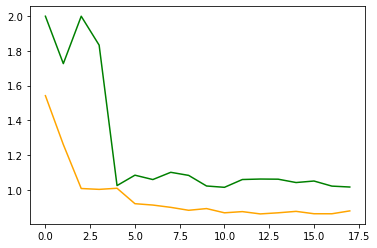

Starting Epoch 18
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 0.755050	Elapsed time: 0:00:00.465037	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.587, -0.657)	FCWeights (Diff, Avg, Total): (0.001961260102689266, 0.04737725853919983, 1552.4580078125)
Train: [6400/1000 (10%)]	Loss: 0.851643	Elapsed time: 0:00:39.392218	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.587, -0.561)	FCWeights (Diff, Avg, Total): (0.0008022765978239477, 0.047377437353134155, 1552.4638671875)
Train: [12800/1000 (20%)]	Loss: 0.856071	Elapsed time: 0:01:18.009254	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.585, -0.561)	FCWeights (Diff, Avg, Total): (0.0005113360239192843, 0.047377534210681915, 1552.467041015625)
Train: [19200/1000 (30%)]	Loss: 0.806921	Elapsed time: 0:01:56.315189	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.592, -0.569)	FCWeights (Diff, Avg, Total): (0.0031099545303732157, 0.04737749695777893, 1552.4658203125)
Train: [25200/1000 (40%)]	Loss: 0.853773	Elapsed time: 0:02

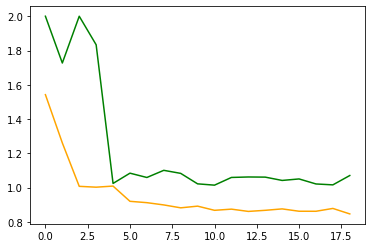

Starting Epoch 19
Will sample from train_loader
Train: [0/1000 (0%)]	Loss: 0.854934	Elapsed time: 0:00:00.353018	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.61, -0.534)	FCWeights (Diff, Avg, Total): (0.0004733677487820387, 0.04737721383571625, 1552.45654296875)
Train: [4300/1000 (10%)]	Loss: 0.841781	Elapsed time: 0:00:38.625526	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.592, -0.565)	FCWeights (Diff, Avg, Total): (2.3818309273337945e-05, 0.04737721383571625, 1552.45654296875)
Train: [12800/1000 (20%)]	Loss: 0.914946	Elapsed time: 0:01:16.407487	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.57, -0.55)	FCWeights (Diff, Avg, Total): (0.00013889800175093114, 0.047377221286296844, 1552.456787109375)
Train: [18900/1000 (30%)]	Loss: 0.865832	Elapsed time: 0:01:55.837198	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.573, -0.552)	FCWeights (Diff, Avg, Total): (0.0011958020040765405, 0.047377198934555054, 1552.4560546875)
Train: [18000/1000 (40%)]	Loss: 0.869160	Elapsed time: 0:

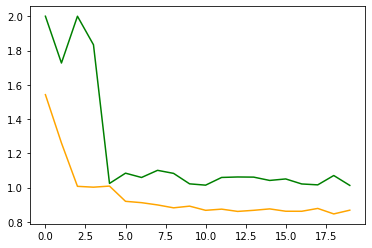

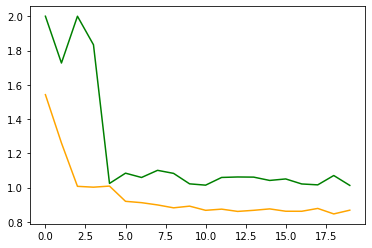

In [3]:
train_loader = DataLoader(training_set, batch_size=1, shuffle=False, num_workers=0)
val_loader = DataLoader(validation_set, batch_size=1, shuffle=False, num_workers=0)
metrics = [EmbeddingCosineSimilarityMetric()]
fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics, measure_weights=True)

## Test trained model

In [5]:
load_state_path = r"C:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\angio_seq_multisiamese_fast\training_state_15.pth"
print(load_state_path)
state = torch.load(load_state_path)
model.load_state_dict(state['model'])
model.eval()   

C:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\angio_seq_multisiamese_fast\training_state_15.pth


DataParallel(
  (module): MultiSiameseNet(
    (embedding_net): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): 

In [6]:
test_path = r'C:\Users\root\Data\Angiographie'
test_set = get_test_set(test_path)

105 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30LAO25CAU
110 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO
104 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO25CAU
78 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_AP
79 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_LAT
121 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_AP
113 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_LAT
75 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30LAO25CRA
78 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30RAO
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_AP
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_LAT
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_AP
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_LAT
48 valid frames in C:\Users\root\Data\Angiogr

Batch 1/56 with 103 sequences


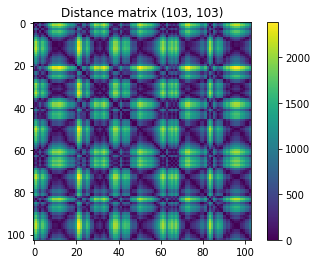

Batch 2/56 with 108 sequences


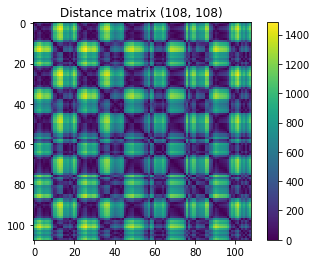

Batch 3/56 with 102 sequences


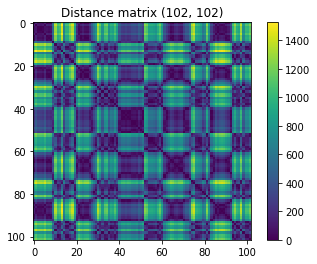

Batch 4/56 with 76 sequences


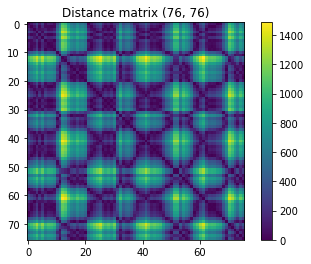

Batch 5/56 with 77 sequences


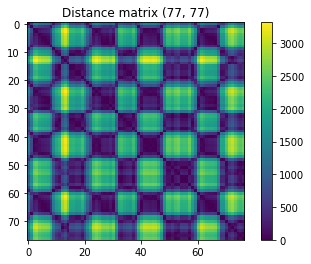

Batch 6/56 with 119 sequences


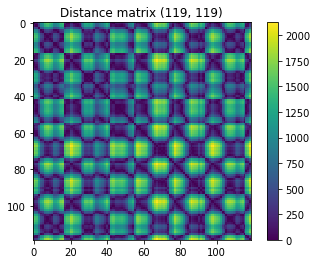

Batch 7/56 with 111 sequences


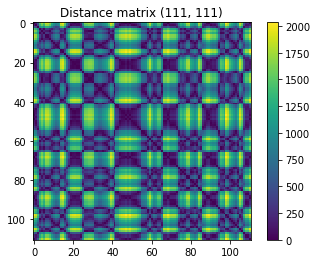

Batch 8/56 with 73 sequences


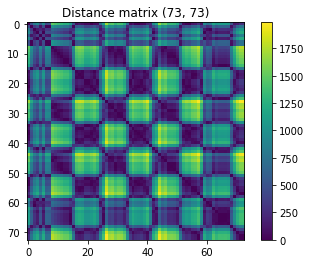

Batch 9/56 with 76 sequences


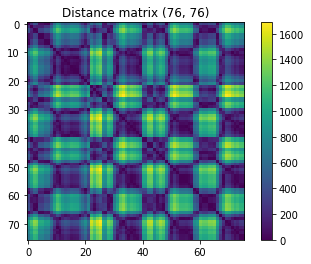

Batch 10/56 with 83 sequences


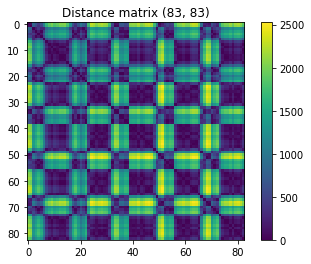

Batch 11/56 with 83 sequences


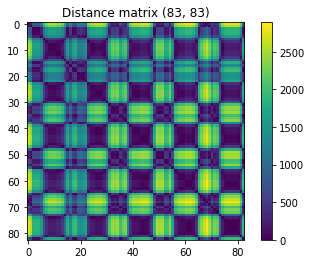

Batch 12/56 with 37 sequences


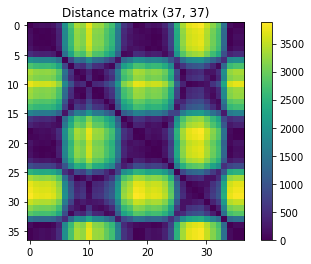

Batch 13/56 with 37 sequences


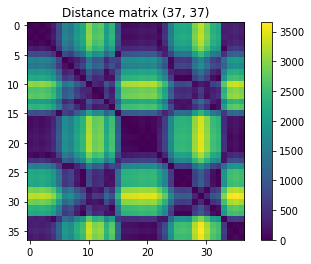

Batch 14/56 with 46 sequences


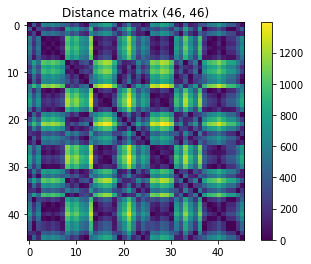

Batch 15/56 with 42 sequences


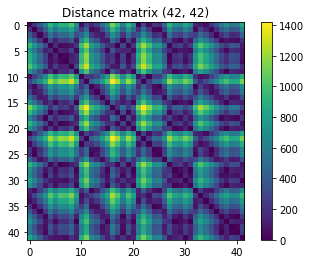

Batch 16/56 with 47 sequences


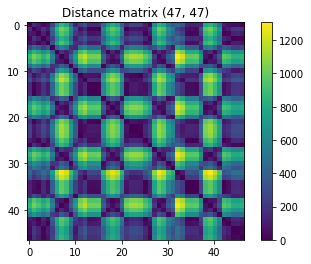

Batch 17/56 with 49 sequences


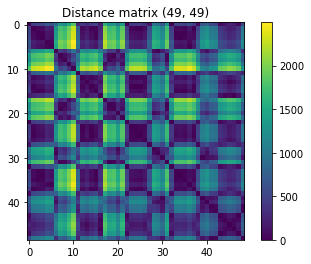

Batch 18/56 with 52 sequences


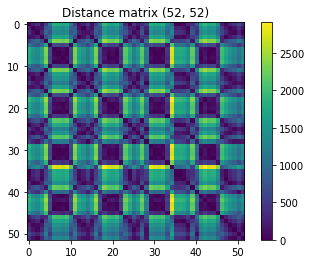

Batch 19/56 with 58 sequences


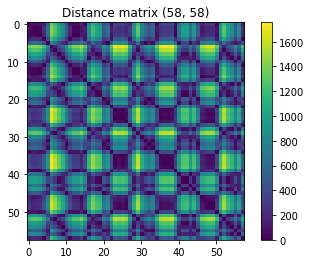

Batch 20/56 with 49 sequences


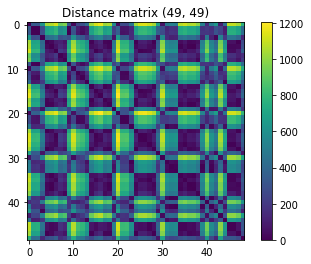

Batch 21/56 with 44 sequences


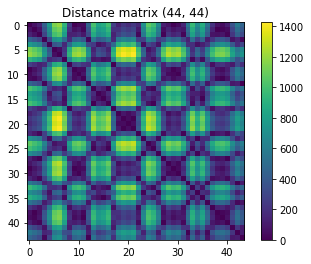

Batch 22/56 with 46 sequences


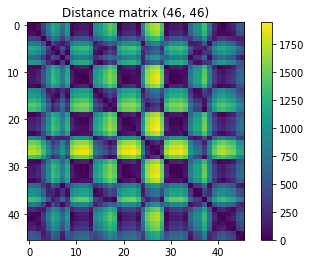

Batch 23/56 with 47 sequences


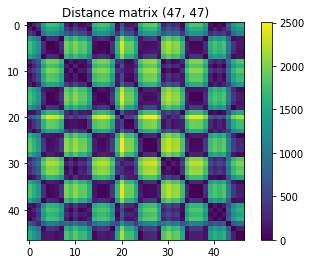

Batch 24/56 with 60 sequences


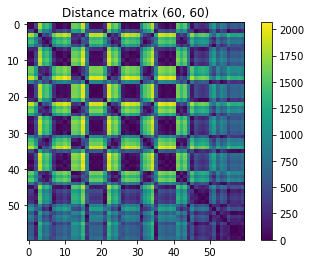

Batch 25/56 with 51 sequences


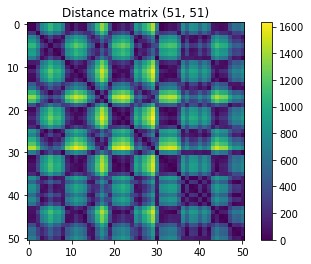

Batch 26/56 with 43 sequences


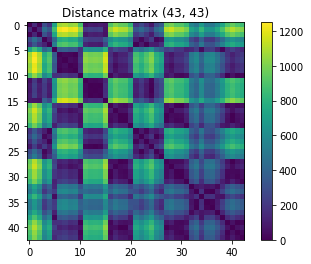

Batch 27/56 with 29 sequences


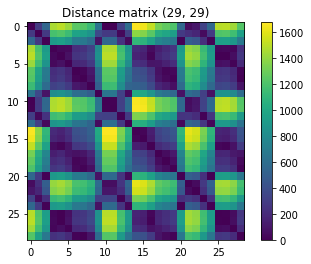

Batch 28/56 with 68 sequences


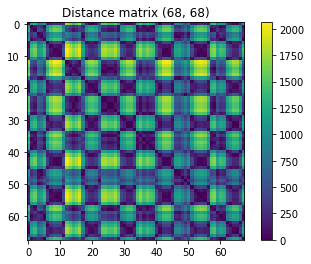

Batch 29/56 with 63 sequences


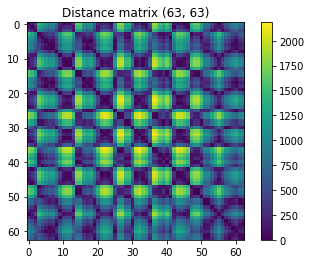

Batch 30/56 with 42 sequences


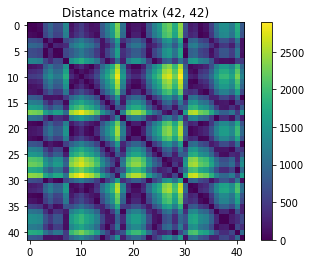

Batch 31/56 with 82 sequences


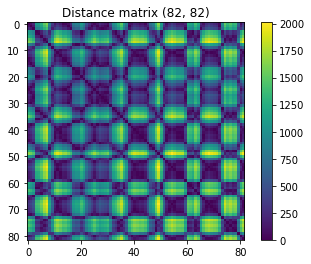

Batch 32/56 with 97 sequences


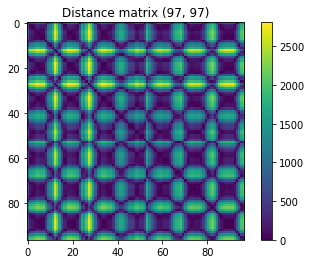

Batch 33/56 with 80 sequences


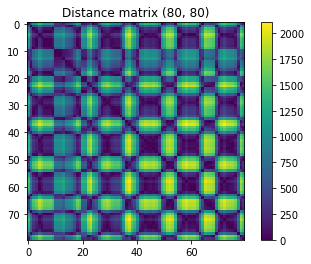

Batch 34/56 with 73 sequences


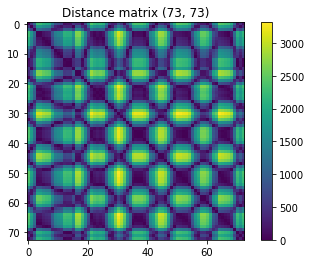

Batch 35/56 with 92 sequences


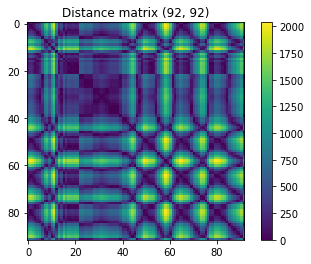

Batch 36/56 with 105 sequences


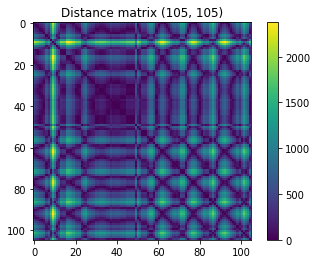

Batch 37/56 with 37 sequences


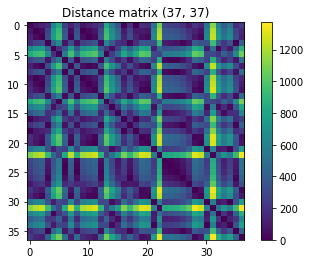

Batch 38/56 with 40 sequences


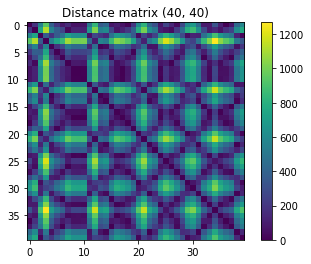

Batch 39/56 with 39 sequences


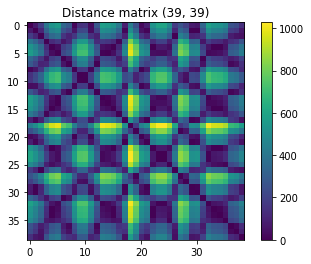

Batch 40/56 with 48 sequences


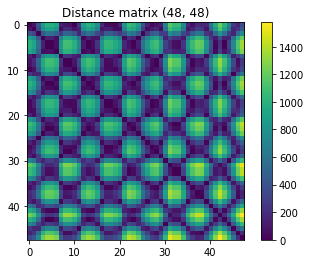

Batch 41/56 with 43 sequences


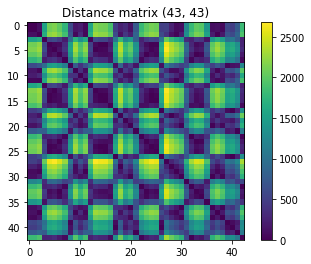

Batch 42/56 with 61 sequences


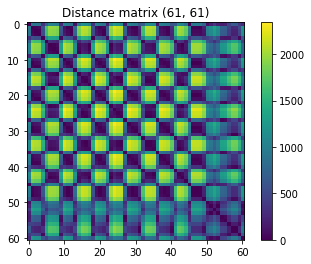

Batch 43/56 with 74 sequences


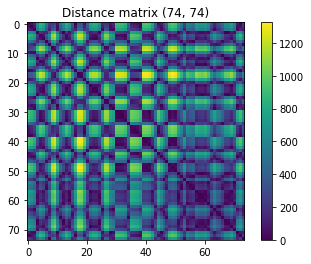

Batch 44/56 with 48 sequences


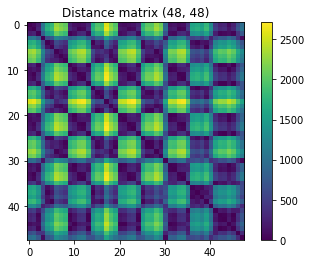

Batch 45/56 with 45 sequences


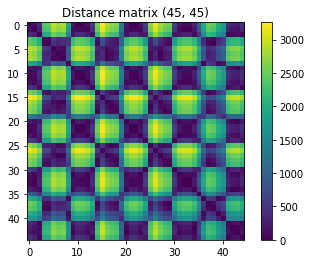

Batch 46/56 with 39 sequences


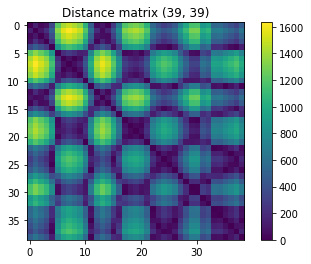

Batch 47/56 with 39 sequences


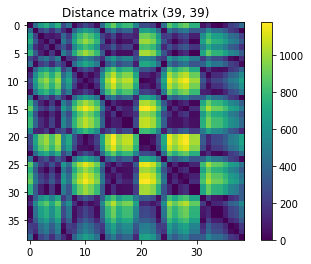

Batch 48/56 with 50 sequences


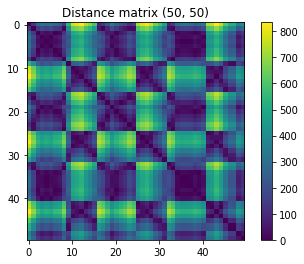

Batch 49/56 with 53 sequences


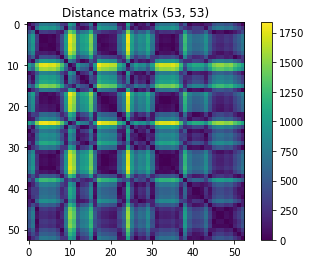

Batch 50/56 with 49 sequences


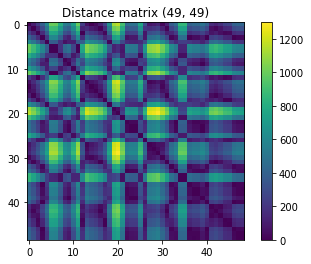

Batch 51/56 with 49 sequences


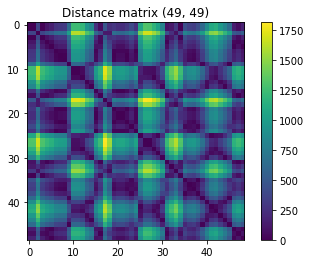

Batch 52/56 with 50 sequences


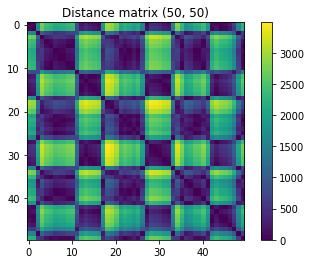

Batch 53/56 with 44 sequences


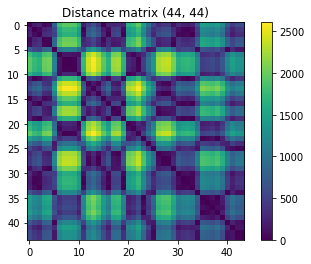

Batch 54/56 with 50 sequences


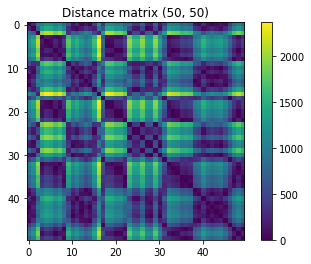

Batch 55/56 with 41 sequences


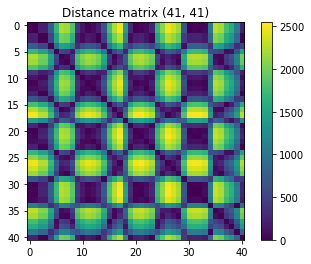

Batch 56/56 with 39 sequences


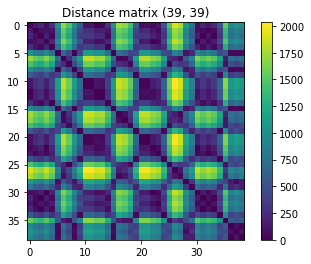

In [7]:
def calc_distance_matrix(embeddings):
    distances = []
    for i in range(len(embeddings)):
        distances_i = []
        for j in range(len(embeddings)):
            if j < i:
                distances_i.append(distances[j][i])
            elif j == i:
                distances_i.append(0)
            else:
                val = torch.sum(torch.abs(embeddings[i] - embeddings[j]))
                distances_i.append(val.cpu().numpy())
        distances.append(distances_i)
    distances = np.array(distances)
    return distances

with torch.no_grad():
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=1)
    for batch_index, sequences in enumerate(test_loader):
        # sequences: (batch, video_frame, channel, width, height)
        embeddings = []
        print (f"Batch {batch_index + 1}/{len(test_loader)} with {len(sequences[0])} sequences")
        for i in range(len(sequences[0])):
            sequence = sequences[:, i]
            embedding = model(sequence) # (1, 1000)
            embeddings.append(embedding)
        distance_matrix = calc_distance_matrix(embeddings)
        plt.imshow(distance_matrix)
        plt.colorbar()
        plt.title(f"Distance matrix {distance_matrix.shape}")
        plt.show()